In [1]:
import glob
import numpy as np 
import xarray as xr
import pandas as pd 
import matplotlib.pyplot as plt 

# Monthly Timestep Experiments 

In [2]:
sources = [ ]

for file in sorted(glob.glob("./nc/50a_dt_*m.nc")):
    with xr.open_dataset(file) as src:
        # Round time to 3 decimals so there is proper alignment
        src["t"] = src.t.round(decimals=3)

        # Apply coordinate transform
        src["Z"] = src.zbed + src.Z * src.height 
    
        # Store the .nc file in the list
        sources.append(src)

# concat the .nc files along a new dimension "timestep"
# use an 'inner' join, meaning only timesteps present in all file are kept
src = xr.concat(sources, join='inner',
                dim = pd.Index(['12m', '1m', '2m', '6m'], name='timestep'))

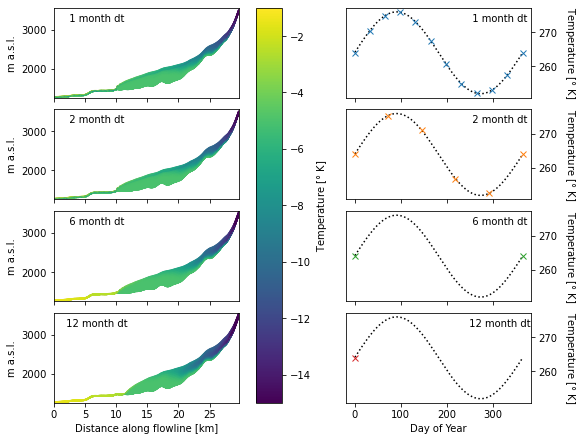

In [3]:
fig, ax = plt.subplots(4,2, figsize=(8,6), 
                       sharex='col', sharey='col', 
                       constrained_layout=True)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

z           = 2300.0    # Node Elevation            [m a.s.l.]
α           = 12.       # Annula air temp amp       [K]
ΔTΔz        = 11/2750.  # Air temp lapse rate       [K m^{-1}]
ref_z       = 0.0       # Reference Elevation       [m]
T_mean      = 273.15    # Mean annual temp at ref_z [K]
accum_days  = 0.0

# Define vector to store MB model data
DOY_v   = np.arange(1,366)
T_sin = α*np.sin(2*np.pi*DOY_v/365) + ΔTΔz*(ref_z - z) + T_mean

dt_names  = ['1m','2m','6m','12m']
timesteps = [1.0, 2.0, 6.0,  12.0]

for i in range(4): 
    im = ax[i, 0].pcolormesh(src.sel(timestep = dt_names[i]).X / 1e3, 
                        src.sel(timestep = dt_names[i]).Z.isel(t=-1), 
                        src.sel(timestep = dt_names[i]).temperature.isel(t=-1), 
                        vmin=-15, vmax=-1, 
                        shading = 'gouraud')
    ax[i,0].text(0.05, 0.85, '{:3.0f} month dt'.format(timesteps[i]), 
                 transform=ax[i,0].transAxes)
    ax[i,0].set_ylabel('m a.s.l.')
    
    # Plot surface boundary forcing 
    dt_m = timesteps[i]
    dt_a = dt_m / 12.0
    NT_a = 12 / dt_m
    color = colors[i]

    DOY = (np.linspace(0,1, int(NT_a))*365).astype(np.int)
    T_s = α*np.sin(2*np.pi*DOY/365) + ΔTΔz*(ref_z - z) + T_mean
    ax[i, 1].plot(DOY_v, T_sin, "k:")
    ax[i, 1].plot(DOY, T_s, 'x', c=color, label = 'dt = {} month'.format(int(dt_m)))
    ax[i, 1].yaxis.tick_right()
    
    ax[i, 1].text(0.65, 0.85, '{:3.0f} month dt'.format(timesteps[i]), 
             transform=ax[i,1].transAxes)
    
    ax[i,1].yaxis.set_label_position("right")
    ax[i,1].set_ylabel('Temperature [$\degree$ K]', rotation=270, labelpad=20)


ax[-1, 0].set_xlabel('Distance along flowline [km]')    
ax[-1, 1].set_xlabel('Day of Year')    

fig.colorbar(im, ax=ax[:,0], label='Temperature [$\degree$ K]')
fig.savefig('/Users/andrewnolan/Desktop/50a_dt_experiment.png', dpi=300, 
            bbox_inches='tight', facecolor='w')

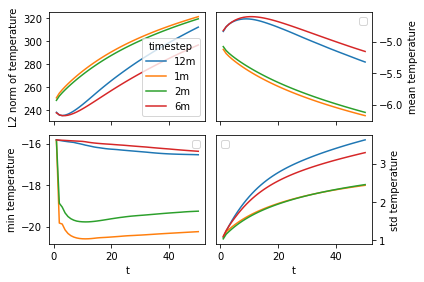

In [4]:
fig, ax = plt.subplots(2,2, sharex=True)

src.temperature.reduce(np.linalg.norm, dim=('coord_1','coord_2'), ord=2).plot.line(ax=ax[0,0], x='t')
ax[0,0].set_ylabel('L2 norm of temperature')
ax[0,0].set_xlabel(None)

src.temperature.reduce(np.mean, dim=('coord_1','coord_2')).plot.line(ax=ax[0,1], x='t')
ax[0,1].set_ylabel('mean temperature')
ax[0,1].set_xlabel(None)
ax[0,1].yaxis.tick_right()
ax[0,1].yaxis.set_label_position("right")
ax[0,1].legend([])

src.temperature.reduce(np.min, dim=('coord_1','coord_2')).plot.line(ax=ax[1,0], x='t')
ax[1,0].set_ylabel('min temperature')
ax[1,0].legend([])

src.temperature.reduce(np.std, dim=('coord_1','coord_2')).plot.line(ax=ax[1,1], x='t')
ax[1,1].set_ylabel('std temperature')
ax[1,1].yaxis.tick_right()
ax[1,1].yaxis.set_label_position("right")
ax[1,1].legend([])

fig.tight_layout()
fig.savefig('/Users/andrewnolan/Desktop/temp_timeseries.png',
            dpi = 300, 
            bbox_inches = 'tight',
            facecolor   = 'w')

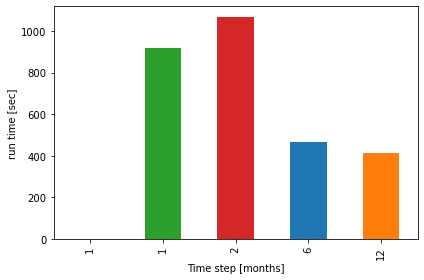

In [5]:
df = pd.read_csv("out.enthalpy_timestep", names = ['dt_m', 'runtime'], delimiter="\t")

fig, ax = plt.subplots(1,1)
df.plot.bar(ax=ax,
            x='dt_m', 
            y='runtime',
            legend=None, 
            color=['tab:orange', 'tab:green', 'tab:red', 'tab:blue'])

ax.set_ylabel('run time [sec]')
ax.set_xlabel('Time step [months]')

fig.tight_layout()
fig.savefig('/Users/andrewnolan/Desktop/timestep_runtimes.png',
            dpi = 300, 
            bbox_inches = 'tight',
            facecolor   = 'w')

# Mean vs. Discrete Experiments 

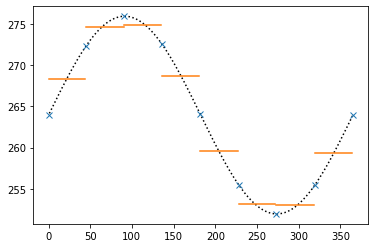

In [6]:
fig, ax = plt.subplots(1,1)
# Define vector to store MB model data
DOY_v   = np.arange(1,366)
T_sin = α*np.sin(2*np.pi*DOY_v/365) + ΔTΔz*(ref_z - z) + T_mean


DOY = (np.linspace(0,1, 9)*365).astype(np.int)
T_s = α*np.sin(2*np.pi*DOY/365) + ΔTΔz*(ref_z - z) + T_mean
ax.plot(DOY_v, T_sin, "k:")
ax.plot(DOY, T_s, "x")

for i, t in enumerate(DOY): 
    if t == 0.0: continue
        
    doy_m = np.arange(DOY[i-1], DOY[i], 1)
    t_m   = np.mean(α*np.sin(2*np.pi*doy_m/365) + ΔTΔz*(ref_z - z) + T_mean) * np.ones_like(doy_m)
    
    plt.plot(doy_m, t_m, c='tab:orange')

In [133]:
sources = [ ]
forcing = [ ]
for file in sorted(glob.glob("./nc/surf_9point_BC_*.nc")):
    forcing.append(file.split('_')[-1].split(".")[0])
    with xr.open_dataset(file) as src:
        # Round time to 3 decimals so there is proper alignment
        src["t"] = src.t.round(decimals=3)

        # Apply coordinate transform
        src["Z"] = src.zbed + src.Z * src.height 
    
        # Store the .nc file in the list
        sources.append(src)

# concat the .nc files along a new dimension "timestep"
# use an 'inner' join, meaning only timesteps present in all file are kept
src = xr.concat(sources,
                dim = pd.Index(forcing, name='forcing'))

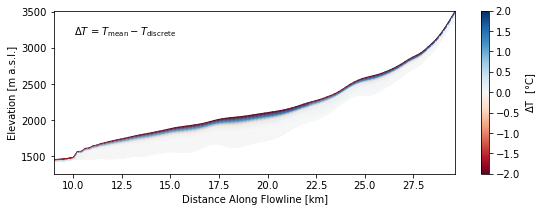

In [134]:
fig, ax = plt.subplots(1,1, figsize=(9,3))

im = ax.pcolormesh(src.isel(t=-1).sel(forcing='mean').X / 1e3,
                      src.isel(t=-1).sel(forcing='mean').Z, 
                      src.isel(t=-1).sel(forcing='mean').temperature - \
                      src.isel(t=-1).sel(forcing='discrete').temperature, 
                      cmap   = 'RdBu',
                      vmin = -2.0, vmax=2.0,
                      shading='gouraud')

ax.text(0.05, 0.85, '$\Delta T$ = $T_{\\rm mean} - T_{\\rm discrete}$', 
        transform=ax.transAxes)

ax.set_xlim(9, None)
ax.set_xlabel('Distance Along Flowline [km]')
ax.set_ylabel('Elevation [m a.s.l.]')

    
fig.colorbar(im, ax=ax, label='$\Delta$T  [$\degree$C]')

fig.savefig('/Users/andrewnolan/Desktop/surf_BC_9point_diff.png',
            dpi = 300,
            bbox_inches='tight',
            facecolor='w')

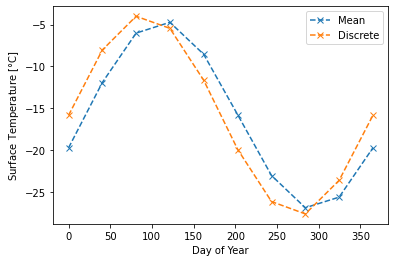

In [144]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot((src.isel(coord_1=-1, coord_2=-1, t=slice(8,18)).sel(forcing='mean').t - 1.0)*365,
           src.isel(coord_1=-1, coord_2=-1, t=slice(8,18)).sel(forcing='mean').temperature,
           'x--',
           label='Mean'
        )

ax.plot((src.isel(coord_1=-1, coord_2=-1, t=slice(8,18)).sel(forcing='discrete').t - 1.0)*365,
           src.isel(coord_1=-1, coord_2=-1, t=slice(8,18)).sel(forcing='discrete').temperature,
           'x--',
           label='Discrete'
        )

ax.legend()

ax.set_xlabel('Day of Year')
ax.set_ylabel('Surface Temperature [$\degree$C]')

fig.savefig('/Users/andrewnolan/Desktop/mean_vs_interp.png',
            dpi = 300,
            bbox_inches='tight',
            facecolor='w')